In [1]:
import pandas as pd
import os
import urllib
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np
from scipy.signal import periodogram
import statsmodels.api as sm
import dask.dataframe as dd

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import warnings
warnings.filterwarnings('ignore')

# Theoretic part 

Multiple choice questions: please select all that applies and explain your answer.

### Question 1 (Autocorrelation).
The autocorrelation plot of the daily time-series has local peaks at t=7,14,21,28 etc.. How would you interpret that?

A. The time-series reaches its maximum on the days 7,14,21,28...

B. The time-series reaches its minimum on the days 7,14,21,28...

C. The time-series is likely to have a periodic pattern with a period of 7 days

D. The time-series is likely to have 7 periods per day

E. The appropriate AR model for the time-series should have at least 7 terms.

Your answer: C. 

There are peaks every 7 days, t=7,14,21,etc.. So we can know that the TS data has a periodic pattern with a period of 7 days

### Question 2 (Stationarity).

Which of the following time-series models are always stationary:

A. Linear trend

B. MA(1) model

C. White noise

D. Random walk

E. ARMA(1,2) model

F. ARIMA(1,1,1) model

Your answer:C. 

White noise is a stationary time series where each value is independent and identically distributed with a mean of zero and constant variance.

### Question 3 (PCA).
Which of the following statements regarding the model dimensionality reduction through Principal Component Analysis (PCA) are true:

A. Leading principal components of the features are the most efficient for modeling the output variable.

B. Principal components of the standardized features are uncorrelated and this way less exposed to multicollinearity.

C. The model using principal components of the features can't overfit.

D. Feature selection based on the principal components of the features is often more efficient in preventing overfitting comparered the feature selection over the original features.

E. Principal components are harder to interpret compared to the original features making the PCA regresssion model less interpretable compared to the regression model using original features.

Your answer: B,D,E.

PCA reduces multicollinearity by transforming original features into uncorrelated principal components, aiding in dimensionality reduction and preventing overfitting by selecting components that capture the most variance. However, the resulting principal components are harder to interpret compared to the original features, potentially reducing the model's interpretability.

### Question 4 (MapReduce).

What is true about MapReduce:

A. MapReduce is a Python module enabling parallel computing

B. Using MapReduce approach makes the code more suitable for parallel computing.

C. MapReduce code always runs faster compared to the code using more traditional approaches, like loops or list comprehensions.

D. MapReduce code will always efficiently run on multiple cores of your CPU or multiple machines within your cluster if available.

E. Multiprocessing and PySpark efficient alternatives to MapReduce.



Your answer: B,E

- B: Using MapReduce approch divides the data processing task into smaller chunks that can be processed independently in parallel across multiple nodes or processors.
- E: Multiprocessing and PySpark offer similar parallel computing capabilities but may have different programming paradigms and implementations tailored to specific use cases or preferences.

# Practice part: Taxi ridership from JFK to other taxi zones prediction.
This project is an example of applying PCA to predict hourly yellow taxi ridership at the taxi zone level. Modeling taxi ridership at a fine spatial and temporal granularity is challenging due to the low signal-to-noise ratio and high dimensionality. In this case, dimension reduction essential in feature engineering. This project has five steps: data downloading, data preprocessing, baseline modeling, feature engineering, and RandomForest modeling.

Let's start with data downloading.

## 1. Data downloading
Design a function to download yellow taxi data from 2017-01-01 to 2018-12-31 at https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page.

In [2]:
dataDir = 'taxidata'
if os.path.exists(dataDir):
    pass
else:
    os.mkdir(dataDir)
Years = [2017,2018]
Months = range(1,13)
VehicleTypes = ['yellow']

def getUrl(cabtype,year,month):
    baseUrl = 'https://d37ci6vzurychx.cloudfront.net/trip-data/'

    month = str(month).zfill(2)
    fileName = '%s_tripdata_%s-%s.parquet'%(cabtype,year,month)

    return baseUrl + fileName, fileName

In [3]:
for year in Years:
    for month in Months:
        for cabtype in VehicleTypes:
            url, fileName = getUrl(cabtype,year,month)

            print("Downloading: "+str(fileName))

            if fileName in os.listdir(dataDir):
                print("file exists")
                continue

            filePath = os.path.join(dataDir, fileName)
            try:
                urllib.request.urlretrieve(url, filePath)
            except:
                # if fails remove the incomplete file
                os.remove(filePath)
                try:
                    # start again after a delay of 2 min
                    time.sleep(60*2)
                    urllib.request.urlretrieve(url, filePath)
                except:
                    print("Download this file later!")
                    pass

Downloading: yellow_tripdata_2017-01.parquet
file exists
Downloading: yellow_tripdata_2017-02.parquet
file exists
Downloading: yellow_tripdata_2017-03.parquet
file exists
Downloading: yellow_tripdata_2017-04.parquet
file exists
Downloading: yellow_tripdata_2017-05.parquet
file exists
Downloading: yellow_tripdata_2017-06.parquet
file exists
Downloading: yellow_tripdata_2017-07.parquet
file exists
Downloading: yellow_tripdata_2017-08.parquet
file exists
Downloading: yellow_tripdata_2017-09.parquet
file exists
Downloading: yellow_tripdata_2017-10.parquet
file exists
Downloading: yellow_tripdata_2017-11.parquet
file exists
Downloading: yellow_tripdata_2017-12.parquet
file exists
Downloading: yellow_tripdata_2018-01.parquet
file exists
Downloading: yellow_tripdata_2018-02.parquet
file exists
Downloading: yellow_tripdata_2018-03.parquet
file exists
Downloading: yellow_tripdata_2018-04.parquet
file exists
Downloading: yellow_tripdata_2018-05.parquet
file exists
Downloading: yellow_tripdata_20

## 2. Data Preprocessing
Use dask to aggregate all months' records into one dataframe, and aggregate dataset by date and hour to get the ridership from JFK to each taxi zone each hour. The expected output has columns: date, hour, drop-off location 1, drop-off location 2, etc.

Hint:
1. JFK taxi zone id is 132.
2. time column should be the pickup time, and ridership is passenger count.
3. Try read_parquet("*.parquet") to read all parquet file in a folder
4. files in 2017 and 2018 have different columns; apply argument usecols to select desired columns.
5. using .compute() function to convert processed dask dataframe to pandas dataframe for further modeling.

### 2.1 Data loading

In [4]:
#your answer here
path = '/Users/14367/Desktop/Study/2024spring/Applied DS/midterm/Midterm/taxidata/*.parquet'
ddf = dd.read_parquet(path,columns={'tpep_pickup_datetime','passenger_count','DOLocationID','PULocationID'})
df = ddf[ddf['PULocationID']==132]
df['tpep_pickup_datetime']=dd.to_datetime(df['tpep_pickup_datetime'])
df['date']=df['tpep_pickup_datetime'].dt.date
df['hour']=df['tpep_pickup_datetime'].dt.hour

In [5]:
agg_df = df.groupby(['date','hour','DOLocationID']).agg({'passenger_count':'sum'})
ndf = agg_df.compute()

In [6]:
ndf = ndf.reset_index()

In [7]:
pivot = ndf.pivot_table(index = {'date','hour'},columns = 'DOLocationID',values ='passenger_count')
data = pivot.fillna(0).astype(int)

In [8]:
data.columns = ['drop-off location {}'.format(int(col)) if col else 'Unknown' for col in data.columns]

In [9]:
data = data.reset_index()

In [10]:
data

,date,hour,drop-off location 1,drop-off location 2,drop-off location 3,drop-off location 4,drop-off location 5,drop-off location 6,drop-off location 7,drop-off location 8,...,drop-off location 256,drop-off location 257,drop-off location 258,drop-off location 259,drop-off location 260,drop-off location 261,drop-off location 262,drop-off location 263,drop-off location 264,drop-off location 265
0,2002-12-31,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2003-01-01,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2003-01-01,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2008-12-31,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2008-12-31,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17538,2018-12-31,23,5,0,0,7,0,0,6,0,...,0,11,0,0,1,1,8,13,0,25
17539,2019-01-16,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17540,2019-02-03,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17541,2019-05-07,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.2 Sanity check
Then, we need to do some basic sanity checks. It is possible that in a particular hour, completely dispatched no yellow taxis from JFK. Check does each day has 24-hour records and add missing records back to the dataframe. The final output should have 17520 rows ($365\times2\times24$)

In [11]:
#your answer here
df = data[(data['date'] >= pd.Timestamp('2017-01-01').date()) & (data['date'] <= pd.Timestamp('2018-12-31').date())]

In [12]:
df = df.reset_index(drop=True)

In [13]:
hourly_counts = df.groupby(['date', 'hour']).size().reset_index(name='count')
missing_hours = []
for date in df['date'].unique():
    missing_hours.extend([(date, hour) for hour in range(24) if (date, hour) not in zip(hourly_counts['date'], hourly_counts['hour'])])

if missing_hours:
    missing_df = pd.DataFrame(missing_hours, columns=['date', 'hour'])
    df = pd.concat([df, missing_df])
    
df.reset_index(drop = True)

,date,hour,drop-off location 1,drop-off location 2,drop-off location 3,drop-off location 4,drop-off location 5,drop-off location 6,drop-off location 7,drop-off location 8,...,drop-off location 256,drop-off location 257,drop-off location 258,drop-off location 259,drop-off location 260,drop-off location 261,drop-off location 262,drop-off location 263,drop-off location 264,drop-off location 265
0,2017-01-01,0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,27.0
1,2017-01-01,1,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,...,6.0,0.0,0.0,0.0,0.0,5.0,7.0,6.0,1.0,12.0
2,2017-01-01,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,2017-01-01,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,2017-01-01,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2018-12-31,21,0.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,...,4.0,5.0,5.0,0.0,1.0,1.0,16.0,13.0,4.0,23.0
17516,2018-12-31,22,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,...,1.0,11.0,0.0,1.0,0.0,5.0,16.0,9.0,0.0,25.0
17517,2018-12-31,23,5.0,0.0,0.0,7.0,0.0,0.0,6.0,0.0,...,0.0,11.0,0.0,0.0,1.0,1.0,8.0,13.0,0.0,25.0
17518,2017-03-12,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = df.fillna(0)
df = df.reset_index(drop = True)

In [15]:
df

,date,hour,drop-off location 1,drop-off location 2,drop-off location 3,drop-off location 4,drop-off location 5,drop-off location 6,drop-off location 7,drop-off location 8,...,drop-off location 256,drop-off location 257,drop-off location 258,drop-off location 259,drop-off location 260,drop-off location 261,drop-off location 262,drop-off location 263,drop-off location 264,drop-off location 265
0,2017-01-01,0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,27.0
1,2017-01-01,1,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,...,6.0,0.0,0.0,0.0,0.0,5.0,7.0,6.0,1.0,12.0
2,2017-01-01,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,2017-01-01,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,2017-01-01,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2018-12-31,21,0.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,...,4.0,5.0,5.0,0.0,1.0,1.0,16.0,13.0,4.0,23.0
17516,2018-12-31,22,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,...,1.0,11.0,0.0,1.0,0.0,5.0,16.0,9.0,0.0,25.0
17517,2018-12-31,23,5.0,0.0,0.0,7.0,0.0,0.0,6.0,0.0,...,0.0,11.0,0.0,0.0,1.0,1.0,8.0,13.0,0.0,25.0
17518,2017-03-12,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Time-series exploratory analysis
Apply exploratory analysis over the daily aggregated dataset at first.

### 3.1 aggregate the ridership from each dropoff location and sum it to get daily records.

In [16]:
#your answer here
daily_agg = df.groupby(['date']).sum().reset_index()
daily_agg['daily_records'] = daily_agg.iloc[:,2:264].sum(axis=1)

In [17]:
daily_agg

,date,hour,drop-off location 1,drop-off location 2,drop-off location 3,drop-off location 4,drop-off location 5,drop-off location 6,drop-off location 7,drop-off location 8,...,drop-off location 257,drop-off location 258,drop-off location 259,drop-off location 260,drop-off location 261,drop-off location 262,drop-off location 263,drop-off location 264,drop-off location 265,daily_records
0,2017-01-01,276,15.0,1.0,0.0,72.0,0.0,4.0,136.0,0.0,...,55.0,38.0,10.0,36.0,31.0,221.0,212.0,35.0,329.0,14381.0
1,2017-01-02,276,13.0,0.0,4.0,74.0,0.0,0.0,192.0,0.0,...,35.0,41.0,8.0,50.0,65.0,227.0,276.0,48.0,315.0,16408.0
2,2017-01-03,276,26.0,0.0,9.0,47.0,0.0,0.0,171.0,2.0,...,50.0,45.0,16.0,55.0,66.0,150.0,221.0,54.0,388.0,15684.0
3,2017-01-04,276,21.0,0.0,3.0,43.0,0.0,5.0,142.0,0.0,...,36.0,32.0,9.0,12.0,62.0,141.0,150.0,42.0,321.0,14228.0
4,2017-01-05,276,8.0,1.0,3.0,58.0,0.0,0.0,83.0,0.0,...,8.0,23.0,4.0,38.0,45.0,77.0,115.0,40.0,305.0,11934.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2018-12-27,276,8.0,0.0,2.0,33.0,0.0,0.0,116.0,1.0,...,21.0,14.0,5.0,45.0,103.0,78.0,93.0,44.0,192.0,12064.0
726,2018-12-28,276,5.0,0.0,4.0,58.0,0.0,1.0,67.0,0.0,...,37.0,28.0,6.0,16.0,84.0,88.0,135.0,29.0,211.0,11906.0
727,2018-12-29,276,8.0,0.0,3.0,21.0,0.0,1.0,99.0,0.0,...,33.0,27.0,6.0,26.0,62.0,100.0,114.0,32.0,254.0,11659.0
728,2018-12-30,276,12.0,0.0,2.0,35.0,1.0,2.0,128.0,0.0,...,56.0,25.0,5.0,32.0,64.0,95.0,157.0,29.0,248.0,11269.0


### 3.2 Period detection and report the strongest period length on the 2017 data.
Hint: using periodogram or acf plot.

In [18]:
data_2017 = daily_agg[(daily_agg['date'] >= pd.Timestamp('2017-01-01').date()) & (daily_agg['date'] <= pd.Timestamp('2017-12-31').date())]
daily_2017 = pd.DataFrame({'date': data_2017.date, 'daily_records': data_2017.daily_records})
daily_2017.reset_index(inplace=True,drop=True)
daily_2017 = daily_2017.set_index('date')

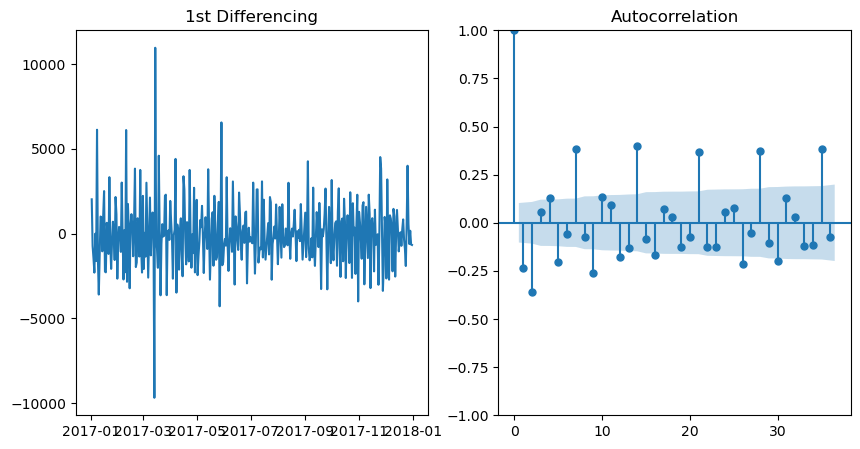

In [19]:
#your answer here
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(daily_2017.daily_records.diff()); axes[0].set_title('1st Differencing')
plot_acf(daily_2017.daily_records.diff().dropna(),lags=36,ax=axes[1])

plt.show()

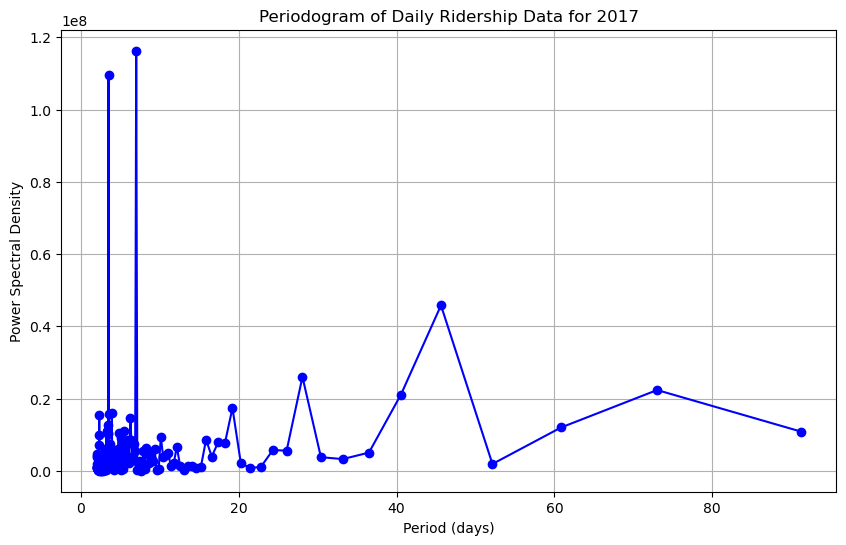

Strongest period length: 7.019230769230769 days


In [20]:
frequencies, psd = periodogram(daily_2017['daily_records'])

psd = psd[frequencies>0.01]
frequencies = frequencies[frequencies>0.01]

strongest_period_length = 1 / frequencies[np.argmax(psd)]

plt.figure(figsize=(10, 6))
plt.plot(1 / frequencies, psd, marker='o', linestyle='-', color='b')
plt.xlabel('Period (days)')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram of Daily Ridership Data for 2017')
plt.grid(True)
plt.show()

print("Strongest period length:", strongest_period_length, "days")

### 3.3 Trend, seasonality, noise decomposition (using additive model) on 2017 data, .

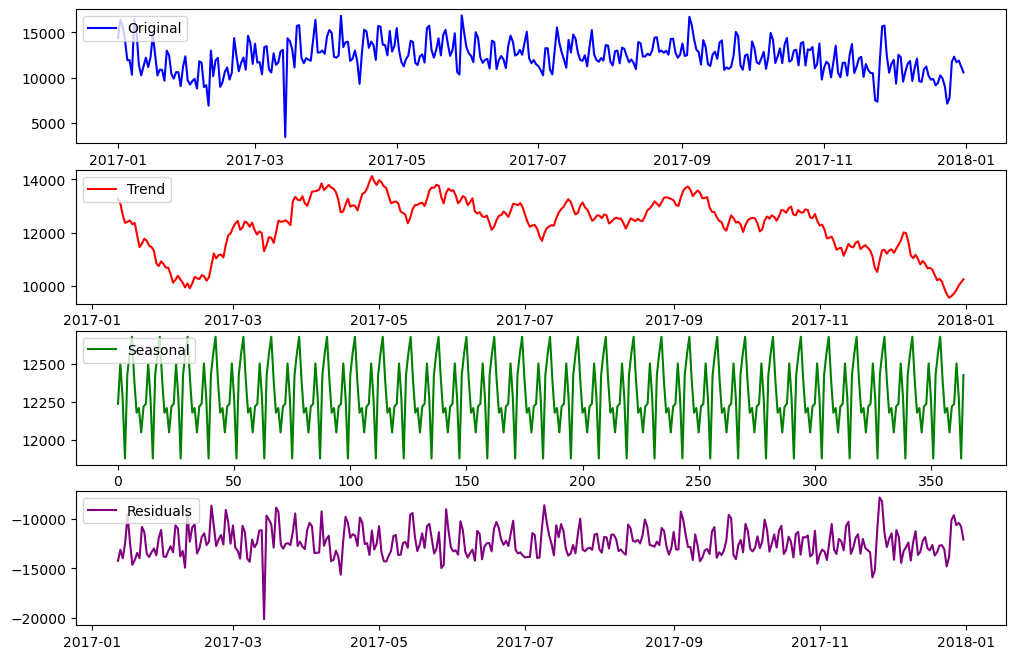

In [21]:
#your answer here
trend = daily_2017['daily_records'].rolling(window=12).mean()

seasonal = np.zeros_like(daily_2017['daily_records'])
period=12
for i in range(period):
    seasonal[i::period] = daily_2017['daily_records'][i::period].mean()

residual = daily_2017['daily_records']- (trend + seasonal)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(daily_2017['daily_records'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='purple')
plt.legend(loc='upper left')
plt.show()

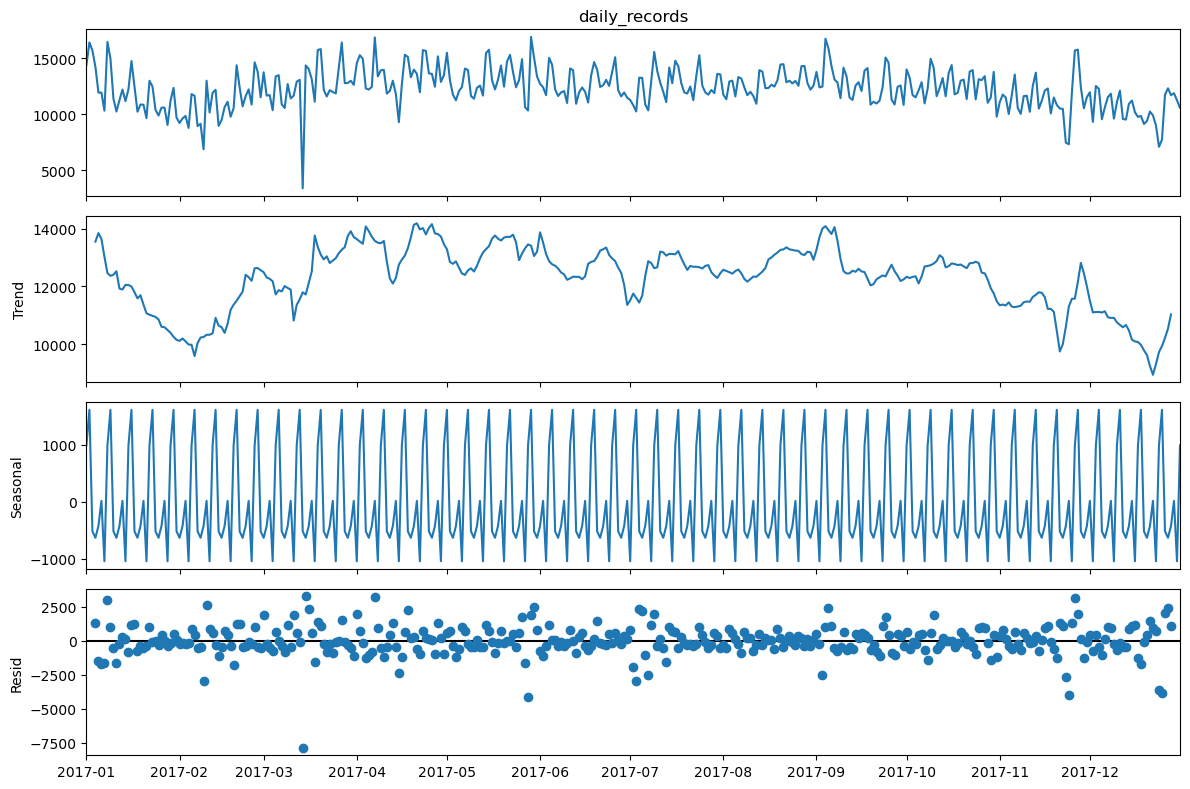

In [22]:
plt.rcParams['figure.figsize'] = [12, 8]
res = sm.tsa.seasonal_decompose(daily_2017['daily_records'], model='additive', period=7)
res.plot()
plt.show()

## 4. Predict the total daily ridership from JFK using ARIMA.
ARIMA is a common method to predict taxi ridership. Before we predict taxi zone level hourly ridership, let's try to predict the aggregated daily ridership using ARIMA.

### 4.1 Using adfuller test to test the stability of the aggregated dataset. If not stable, apply differencing method until the p-value from adfuller test is smaller than 0.05.

In [23]:
#your answer here
series=daily_agg['daily_records'].dropna()
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    diff = series.diff().dropna()
    adf_result_diff = adfuller(diff)
    print(f'Differenced ADF Statistic: {adf_result_diff[0]}')
    print(f'Differenced p-value: {adf_result_diff[1]}')

ADF Statistic: -2.155197
p-value: 0.222906
Differenced ADF Statistic: -8.172850777598752
Differenced p-value: 8.530315080118684e-13


### 4.2 build an ARIMA model using terms [P=0, D=1, Q=1], training on the first 700 days, forecast on the last 31 days. Print ARIMA model results and plot in-sample and out-of-sample prediction in different colors.

In [24]:
P=0
D=1
Q=1

# fit model
N = 700
#your answer here

series = daily_agg['daily_records']

model = sm.tsa.ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          daily_records   No. Observations:                  700
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6234.772
Date:                Sat, 16 Mar 2024   AIC                          12473.543
Time:                        19:33:10   BIC                          12482.643
Sample:                             0   HQIC                         12477.061
                                - 700                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2118      0.025     -8.514      0.000      -0.261      -0.163
sigma2      3.249e+06   1.17e+05     27.795      0.000    3.02e+06    3.48e+06
Ljung-Box (L1) (Q):                   9.84   Jarque-

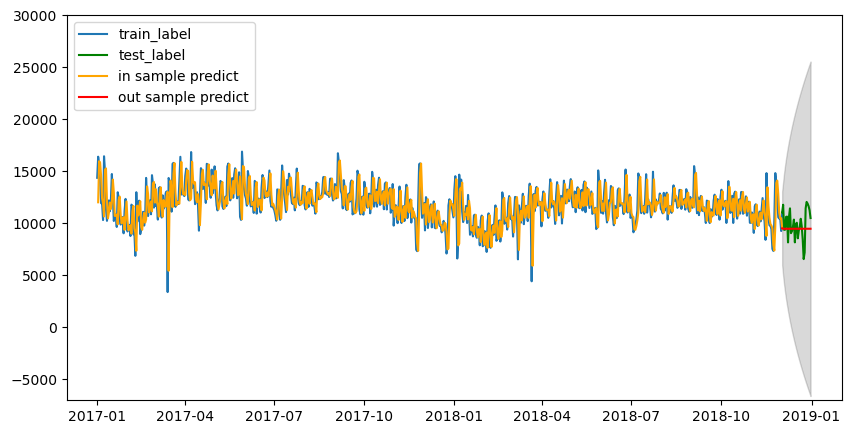

In [25]:
fcast = model_fit.forecast(steps=len(series)-N)
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()

fc_series = pd.Series(fc['mean'], index=range(N,len(series)))
#mean_series = pd.Series(fc['mean'], index=range(N,len(series)))
lower_series = pd.Series(fc.mean_ci_lower, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper, index=range(N,len(series)))
fc_series=pd.DataFrame(fc_series)

#lower_series.index = nindex
#upper_series.index = nindex

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
plt.xlim((pd.Timestamp('2016-12-01').date(), pd.Timestamp('2019-02-01').date()))
plt.ylim((-7000,30000))
ax.plot(daily_agg.date[:N+1],series[:N+1],label='train_label') # train
ax.plot(daily_agg.date[N:],series[N:],color='green',label='test_label') # test
ax.plot(daily_agg.date.iloc[1:N+1],model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
        color='orange',label='in sample predict') # in-sample
ax.plot(daily_agg.date[N:],fc_series, label='out sample predict', color='red') # forecast
ax.fill_between(daily_agg.date.iloc[N:], lower_series, upper_series, color='k', alpha=.15) # conf
ax.legend(loc='upper left')

# Taxi zone level prediction

This project aims to predict hourly yellow taxi ridership volume from JFK to each taxi zone. The ARIMA experiment in section 3 forecasts the total ridership amount from JFK. However, based on the reported $R^2$, this model is not a good fit. ARIMA model has four main shortcomings: 1) they rely heavily on stationarity assumption which does not hold in real-world traffic systems 2) they do not consider spatial and structural dependencies that traffic networks exhibit and forecast each sensor as an individual time series 3) they are unable to model non-linear temporal dynamics 4) they suffer from the curse of dimensionality. Due to the limitation of ARIMA, we need to apply another method to predict taxi zone level ridership.

## 5. Feature engineering

Our workflow is first standardizing the dataset, then using PCA to compress the dataset. As we predict future ridership, PCA should be learned from historical data (2017) then apply to the following year (2018). Next, add lag features (PCA components) from the past 12 hours and apply a Random Forest regressor to predict each PCA component's values in the next hour. After we had the PCA component prediction, inverse PCA, and inverse standardization to retrieve taxi ridership prediction in its original scale and dimension, in other words, we are predicting the PCA components instead of taxi zone level ridership and then using the inverse PCA method to reconstruct

In [26]:
#your answer here
dailydata2017 = daily_agg[daily_agg.date <= pd.to_datetime("2017-12-31").date()].iloc[:,:265]
dailydata2017.set_index('date', inplace=True)
daily2017 = dailydata2017.iloc[:,1:264]
daily2017

,drop-off location 1,drop-off location 2,drop-off location 3,drop-off location 4,drop-off location 5,drop-off location 6,drop-off location 7,drop-off location 8,drop-off location 9,drop-off location 10,...,drop-off location 256,drop-off location 257,drop-off location 258,drop-off location 259,drop-off location 260,drop-off location 261,drop-off location 262,drop-off location 263,drop-off location 264,drop-off location 265
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,15.0,1.0,0.0,72.0,0.0,4.0,136.0,0.0,27.0,128.0,...,127.0,55.0,38.0,10.0,36.0,31.0,221.0,212.0,35.0,329.0
2017-01-02,13.0,0.0,4.0,74.0,0.0,0.0,192.0,0.0,11.0,116.0,...,135.0,35.0,41.0,8.0,50.0,65.0,227.0,276.0,48.0,315.0
2017-01-03,26.0,0.0,9.0,47.0,0.0,0.0,171.0,2.0,17.0,161.0,...,123.0,50.0,45.0,16.0,55.0,66.0,150.0,221.0,54.0,388.0
2017-01-04,21.0,0.0,3.0,43.0,0.0,5.0,142.0,0.0,3.0,147.0,...,125.0,36.0,32.0,9.0,12.0,62.0,141.0,150.0,42.0,321.0
2017-01-05,8.0,1.0,3.0,58.0,0.0,0.0,83.0,0.0,8.0,182.0,...,115.0,8.0,23.0,4.0,38.0,45.0,77.0,115.0,40.0,305.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,5.0,0.0,4.0,41.0,0.0,1.0,125.0,0.0,13.0,142.0,...,101.0,31.0,32.0,4.0,43.0,79.0,88.0,137.0,38.0,204.0
2017-12-28,13.0,1.0,3.0,30.0,0.0,0.0,79.0,0.0,5.0,163.0,...,89.0,33.0,20.0,9.0,45.0,71.0,99.0,68.0,45.0,174.0
2017-12-29,21.0,0.0,2.0,40.0,0.0,4.0,119.0,0.0,7.0,134.0,...,132.0,59.0,21.0,4.0,33.0,73.0,79.0,135.0,30.0,182.0


In [27]:
dailydata2018 = daily_agg[daily_agg.date >= pd.to_datetime("2018-01-01").date()].iloc[:,:265]
dailydata2018.set_index('date', inplace=True)
daily2018 = dailydata2018.iloc[:,1:265]
daily2018

,drop-off location 1,drop-off location 2,drop-off location 3,drop-off location 4,drop-off location 5,drop-off location 6,drop-off location 7,drop-off location 8,drop-off location 9,drop-off location 10,...,drop-off location 256,drop-off location 257,drop-off location 258,drop-off location 259,drop-off location 260,drop-off location 261,drop-off location 262,drop-off location 263,drop-off location 264,drop-off location 265
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,21.0,0.0,3.0,50.0,1.0,0.0,136.0,0.0,12.0,112.0,...,111.0,39.0,22.0,16.0,55.0,68.0,197.0,181.0,22.0,276.0
2018-01-02,11.0,0.0,16.0,53.0,0.0,2.0,185.0,0.0,6.0,151.0,...,92.0,24.0,31.0,9.0,33.0,70.0,126.0,193.0,23.0,366.0
2018-01-03,24.0,0.0,1.0,60.0,0.0,0.0,158.0,0.0,14.0,104.0,...,99.0,19.0,39.0,3.0,25.0,87.0,124.0,176.0,25.0,242.0
2018-01-04,19.0,0.0,2.0,17.0,0.0,0.0,55.0,0.0,21.0,108.0,...,39.0,13.0,39.0,4.0,26.0,16.0,39.0,56.0,16.0,310.0
2018-01-05,39.0,0.0,2.0,23.0,1.0,0.0,61.0,0.0,7.0,111.0,...,54.0,16.0,25.0,8.0,24.0,41.0,67.0,81.0,18.0,224.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,8.0,0.0,2.0,33.0,0.0,0.0,116.0,1.0,5.0,136.0,...,109.0,21.0,14.0,5.0,45.0,103.0,78.0,93.0,44.0,192.0
2018-12-28,5.0,0.0,4.0,58.0,0.0,1.0,67.0,0.0,4.0,163.0,...,89.0,37.0,28.0,6.0,16.0,84.0,88.0,135.0,29.0,211.0
2018-12-29,8.0,0.0,3.0,21.0,0.0,1.0,99.0,0.0,11.0,112.0,...,109.0,33.0,27.0,6.0,26.0,62.0,100.0,114.0,32.0,254.0


### 5.1. standardization.
The standardscaler stores information of this standardization process, including the mean and standard deviation values required when converting the prediction back to the raw scale. Split the whole dataset into two parts: 2017 and 2018, standardize each separately.

In [28]:
#your answer here
sc = StandardScaler()
daily2017sc = sc.fit_transform(daily2017)
print('daily 2017 StandardScaler:\n',daily2017sc)
daily2018sc = sc.fit_transform(daily2018)
print('\n\ndaily 2018 StandardScaler:\n',daily2018sc)

daily 2017 StandardScaler:
 [[ 0.29513597  2.09537592 -1.34348862 ...  2.94616367  0.5696591
   0.55195171]
 [ 0.03045629 -0.20135745 -0.35133213 ...  4.94142019  1.98857377
   0.33910187]
 [ 1.75087423 -0.20135745  0.88886349 ...  3.22674662  2.64345746
   1.44896176]
 ...
 [ 1.08917502 -0.20135745 -0.84741038 ...  0.54562066  0.02392269
  -1.68297162]
 [-0.63124291 -0.20135745  1.13690261 ...  0.60797243 -1.8315811
  -1.22686482]
 [ 0.03045629 -0.20135745  1.63298086 ...  1.9485354   0.67880638
  -0.23863341]]


daily 2018 StandardScaler:
 [[ 0.85262666 -0.14185547 -0.53537997 ...  2.31142685 -0.63079164
  -0.01935339]
 [-0.34709859 -0.14185547  2.51063678 ...  2.70320927 -0.5118051
   1.38099622]
 [ 1.21254424 -0.14185547 -1.00399794 ...  2.14818417 -0.27383203
  -0.54837435]
 ...
 [-0.70701617 -0.14185547 -0.53537997 ...  0.12397499  0.55907372
  -0.36166107]
 [-0.22712607 -0.14185547 -0.76968895 ...  1.527862    0.20211412
  -0.45501771]
 [-0.46707112 -0.14185547 -0.76968895 ...  

### 5.2. PCA

Train PCA on the standardized 2018 dataset. Set PCA components as 5, and gamma is None, use kernel ‘linear’. Report the mean squared error between the standardized data and reconstructed data. Hint: fit the PCA on 2017 data and apply it to transform 2018 data. (5 pts)

In [29]:
#your answer here
kpca = KernelPCA(kernel='linear', gamma=None, n_components=5, fit_inverse_transform=True)
X_kpca = kpca.fit_transform(daily2017sc)
kpac_trans = kpca.transform(daily2018sc)
daily2018re = kpca.inverse_transform(kpac_trans)
mse = mean_squared_error(daily2018sc, daily2018re)
print("Mean Squared Error: {:.4f}".format(mse))

Mean Squared Error: 0.7467


### 5.3 Add lag
add 12 lags of each component (pca_comps=5) (compressed 2018 data only). The expected output should have 65 dimensions. In the further modeling step, we will apply the 60 lag variables to predict the 5 components.

In [30]:
#your answer here
pca2018 = pd.DataFrame(kpac_trans, columns=['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5'])
for i in range(5):
    component_name = 'Component {}'.format(i+1)
    for lag in range(1, 13):
        pca2018['{}_lag{}'.format(component_name, lag)] = pca2018[component_name].shift(lag)
lag2018 = pca2018.dropna()
X_lagged = lag2018.drop(['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5'], axis=1)
y = lag2018[['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5']]

In [31]:
lag2018

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 1_lag1,Component 1_lag2,Component 1_lag3,Component 1_lag4,Component 1_lag5,...,Component 5_lag3,Component 5_lag4,Component 5_lag5,Component 5_lag6,Component 5_lag7,Component 5_lag8,Component 5_lag9,Component 5_lag10,Component 5_lag11,Component 5_lag12
12,0.337106,-0.229541,-0.193369,-1.576094,-1.792890,3.827230,0.381761,3.987154,-1.571323,-12.331964,...,-2.759611,-2.672291,-5.310180,-4.155880,-4.289344,-3.059928,-1.961128,-4.073603,-2.379269,0.493403
13,4.069089,-0.436812,4.925244,1.039840,-4.002934,0.337106,3.827230,0.381761,3.987154,-1.571323,...,-2.957479,-2.759611,-2.672291,-5.310180,-4.155880,-4.289344,-3.059928,-1.961128,-4.073603,-2.379269
14,-5.246084,5.844264,4.412574,2.031310,-3.722999,4.069089,0.337106,3.827230,0.381761,3.987154,...,-1.717411,-2.957479,-2.759611,-2.672291,-5.310180,-4.155880,-4.289344,-3.059928,-1.961128,-4.073603
15,-0.125561,-1.697340,2.129727,3.624774,-1.046462,-5.246084,4.069089,0.337106,3.827230,0.381761,...,-1.792890,-1.717411,-2.957479,-2.759611,-2.672291,-5.310180,-4.155880,-4.289344,-3.059928,-1.961128
16,8.293642,-3.013577,2.034927,2.084191,-0.983419,-0.125561,-5.246084,4.069089,0.337106,3.827230,...,-4.002934,-1.792890,-1.717411,-2.957479,-2.759611,-2.672291,-5.310180,-4.155880,-4.289344,-3.059928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-3.843191,1.008333,2.636882,-1.047851,-3.358312,-0.177086,15.160615,16.935218,11.412465,6.601646,...,-1.702686,-1.327772,1.186029,-0.508583,-0.823348,0.366766,-0.092338,-0.654432,-0.480567,1.938286
361,-3.697279,-0.169650,3.077642,-1.743006,-2.598999,-3.843191,-0.177086,15.160615,16.935218,11.412465,...,-0.951862,-1.702686,-1.327772,1.186029,-0.508583,-0.823348,0.366766,-0.092338,-0.654432,-0.480567
362,-2.564623,1.973833,4.334164,-2.765596,-1.025082,-3.697279,-3.843191,-0.177086,15.160615,16.935218,...,-1.621812,-0.951862,-1.702686,-1.327772,1.186029,-0.508583,-0.823348,0.366766,-0.092338,-0.654432
363,-3.532083,-0.091842,8.426272,-0.340317,-1.418376,-2.564623,-3.697279,-3.843191,-0.177086,15.160615,...,-3.358312,-1.621812,-0.951862,-1.702686,-1.327772,1.186029,-0.508583,-0.823348,0.366766,-0.092338


## 6. RandomForest modeling

We aim at predicting compressed daily ridership (5 PCA components values) from 12-hour lag variables. Parameter tuning is required in this section, including min_samples_split, min_samples_leaf, and n_estimators. First 80% days for training, test on the rest 20%. And in the training dataset, validate the model on the bottom 20%.


### 6.1 train test split
Please keep in mind that random train test split is not applicable in this case.

In [32]:
#your answer here
X = lag2018.iloc[:, 5:]
y = lag2018.iloc[:, :5]
i = int(0.8 * len(X))
X_train, y_train = X[:i], y[:i]
X_test, y_test = X[i:], y[i:]

### 6.2 model performance measurement
Use the RandomForest model with the provided parameters (min_samples_split: 2, min_samples_leaf: 10, and n_estimators equal to 50.) to predict the compressed daily ridership. Prediction results are PCA components instead of taxi zone level ridership. To reconstruct the data back to its original size and scale, we need to inverse PCA and inverse standardization. report the taxi zone level R² value.




In [33]:
#your answer here
rf_model = RandomForestRegressor(min_samples_split=2, min_samples_leaf=10, n_estimators=50)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred = kpca.inverse_transform(y_pred)
y_test = kpca.inverse_transform(y_test)
y_pred = sc.inverse_transform(y_pred)
y_test = sc.inverse_transform(y_test)

In [34]:
r2 = r2_score(y_test, y_pred)
print(f'the R2 is {r2}')

the R2 is -0.20545623293031948
